In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import matplotlib.colors as clr
import matplotlib.cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

In [2]:
def treshold_data_criterion(treshold):
    return lambda x: x>=treshold

def change_cmap(cmap,a,b,n=8,boolean=False,treshold=0.5,interv=None):
    new_colors=[]
    if boolean:
        for x in np.linspace(a,b,2**n):
            if boolean:
                if x<treshold:
                    new_colors.append(cmap(0))
                else:
                    new_colors.append(cmap(1.0))
    elif interv is not None:
        if b>a:
            for x in np.linspace(a,b,2**n):
                new_colors.append(cmap(np.floor((x-a)/interv)*interv/(b-a)))
        else:
            for x in np.linspace(a,b,2**n):
                new_colors.append(cmap(1.0))
    return clr.ListedColormap(new_colors)

indxs=np.arange(-1,2)
indxs=list(map(lambda x: x.flatten(),np.meshgrid(indxs,indxs)))
neighbors=np.array(list(zip(indxs[0],indxs[1])))
neighbors=np.delete(neighbors,4,axis=0)
neighbors_order=np.array([0,1,2,4,7,6,5,3])
neighbors=neighbors[neighbors_order]
#print(neighbors)       

In [3]:
class padded_array:

    def __init__(self,arr,x,y,pad_mode='edge'):
        self.data=np.pad(arr,1,pad_mode)
        self.x=x
        self.y=y
    
    def shift(self,i,j):
        return self.data[1+i:1+self.x+i,1+j:1+self.y+j] 


In [8]:
class raster_data:

    def __init__(self,from_path=False,input_path="",raster=None,profile=None,nodata_value=-1000,data_criterion=treshold_data_criterion(0),name="Raster data",treshold_val=None,pad_mode='edge'):

        self.nodata=nodata_value
        self.name=name
        self.treshold_val=treshold_val
        
        if from_path:
            with rasterio.open(input_path) as src:
                self.data = src.read()[0,:,:]
                self.profile = src.profile

            if self.nodata is not None:
                self.data=np.where(data_criterion(self.data),self.data,self.nodata)

        else:
            self.data=raster
            self.profile=profile

        self.x,self.y = self.data.shape
        self.max=np.nanmax(self.data)
        self.min=np.nanmin(self.data)
        self.range=self.max-self.min
        self.pad_mode=pad_mode
    
    def set_name(self,name):
        self.name=name

    def crop(self,crop_x,crop_y):

        x0=int(crop_x[0]*self.x)
        x1=int(crop_x[1]*self.x)
        y0=int(crop_y[0]*self.y)
        y1=int(crop_y[1]*self.y)

        return raster_data(raster=self.data[x0:x1,y0:y1],profile=self.profile,name=self.name,treshold_val=self.treshold_val,nodata_value=self.nodata,pad_mode=self.pad_mode)
    
    def tresholded(self,treshold,name=None,boolean=True):

        if name is None:
            name=self.name
        
        treshold_val=treshold
        if treshold>np.max(self.data):
            treshold_val=None

        if boolean:
            for_matching=1
        else:
            for_matching=self.data
        
        return raster_data(raster=np.where(self.data>self.nodata,np.where(self.data>treshold,for_matching,0),self.nodata),profile=self.profile,name=name,treshold_val=treshold_val,nodata_value=self.nodata,pad_mode=self.pad_mode)

    def padded(self,pad_width=1,pad_mode='constant',pad_vals=(0,0),name=None):

        if name is None:
            name=self.name

        return raster_data(raster=np.pad(self.data,pad_width,pad_mode,constant_values=pad_vals),profile=self.profile,name=name,treshold_val=self.treshold_val,nodata_value=self.nodata,pad_mode=self.pad_mode)

    
    def visualize(self,cmap=plt.cm.viridis,crop_x=[0,1],crop_y=[0,1],fig=None,ax=None,figsize=(10,10),title=None,boolean=False,discrete=None,alpha=1,cbar=True,draw_pixel_grid=False,grid_color="white"):

        if fig is None or ax is None:
            fig,ax=plt.subplots(figsize=figsize)

        if title is None:
            title=self.name

        cropped=self.crop(crop_x,crop_y)

        cropped=raster_data(raster=np.where(cropped.data>cropped.nodata,cropped.data,np.nan),profile=self.profile,name=self.name,treshold_val=self.treshold_val,pad_mode=self.pad_mode)

        change=boolean or (discrete is not None)
        
        if change:
            cmap=change_cmap(cmap,cropped.min,cropped.max,treshold=cropped.treshold_val,boolean=boolean,interv=discrete)

        sc=ax.imshow(cropped.data,cmap=cmap,alpha=alpha)
        if cbar:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="5%", pad=0.05)
            if discrete is not None:
                pos=np.arange(int(cropped.range/discrete)+1)*discrete+cropped.min
                bar = fig.colorbar(sc,cax=cax,orientation='horizontal',spacing='proportional',ticks=discrete/2+pos,boundaries=np.append(pos,pos[-1]+discrete))     
                bar.ax.set_xticklabels((pos).astype(type(discrete)))
            else:
                bar = fig.colorbar(sc,cax=cax,orientation='horizontal')
        if draw_pixel_grid: 
            ax.set_yticks(np.arange(-0.5, x1-x0, 1), minor=True)
            ax.set_xticks(np.arange(-0.5, y1-y0, 1), minor=True)
            ax.grid(color=grid_color,lw=1,which='minor')
        else:
            ax.set_xticks([])
            ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(title,y=1.03)

    def multiply_by(self,fac,name=None):

        if name is None:
            name=self.name
        
        if isinstance(fac,raster_data):
            return raster_data(raster=np.where(self.data>self.nodata,fac.data*self.data,self.nodata),profile=self.profile,name=name,treshold_val=self.treshold_val,nodata_value=self.nodata,pad_mode=self.pad_mode)    
        else:
            return raster_data(raster=np.where(self.data>self.nodata,fac*self.data,self.nodata),profile=self.profile,name=name,treshold_val=self.treshold_val,nodata_value=self.nodata,pad_mode=self.pad_mode)

    def add(self,cst,name=None):

        if name is None:
            name=self.name
        
        if isinstance(cst,raster_data):
            return raster_data(raster=np.where(self.data>self.nodata,cst.data+self.data,self.nodata),profile=self.profile,name=name,treshold_val=self.treshold_val,nodata_value=self.nodata,pad_mode=self.pad_mode)    
        else:
            return raster_data(raster=np.where(self.data>self.nodata,cst+self.data,self.nodata),profile=self.profile,name=name,treshold_val=self.treshold_val,nodata_value=self.nodata,pad_mode=self.pad_mode)

    def equal_to(self,val=1,name=None):

        if name is None:
            name=self.name
        
        return raster_data(raster=np.where(self.data==val,1,0),profile=self.profile,name=name,treshold_val=self.treshold_val,pad_mode=self.pad_mode)

    def normalize_positive(self):
        
        dummy = self.tresholded(0,boolean=False)
        return dummy.multiply_by(1.0/dummy.max)
    
    def skeletonize_B(self,boolean=True,last_check=False):
        arr=padded_array(self.data,self.x,self.y,pad_mode=self.pad_mode)
        B=sum(map(lambda n: arr.shift(n[0],n[1]),neighbors))
        if last_check:
            B=np.where(B>=7,0,1)
        elif boolean:
            B=np.where((B-2)*(B-6)<=0,1,0)
        return raster_data(raster=B,profile=self.profile,name="B",treshold_val=0.5,pad_mode=self.pad_mode)

    def skeletonize_A(self,boolean=True):
        arr=padded_array(self.data,self.x,self.y,pad_mode=self.pad_mode)
        A_prep=np.zeros_like(self.data)
        A=sum(map(lambda i: np.where(arr.shift(neighbors[i][0],neighbors[i][1])==0,1,0)*np.where(arr.shift(neighbors[(i+1)%8][0],neighbors[(i+1)%8][1])>0,1,0),np.arange(8)))        
        if boolean:
            A=np.where(A==1,1,0)
        return raster_data(raster=A,profile=self.profile,name="A",treshold_val=0.5,pad_mode=self.pad_mode)
        
    def skeletonize_D(self,boolean=True,iter2=False):
        arr=padded_array(self.data,self.x,self.y,pad_mode=self.pad_mode)
        if iter2:
            D=arr.shift(-1,0)*arr.shift(0,1)*arr.shift(0,-1)
        else:
            D=arr.shift(-1,0)*arr.shift(0,1)*arr.shift(1,0)
        if boolean:
            D=np.where(D!=1,1,0)
        return raster_data(raster=D,profile=self.profile,name="D",treshold_val=0.5,pad_mode=self.pad_mode)

    def skeletonize_E(self,boolean=True,iter2=False):
        arr=padded_array(self.data,self.x,self.y,pad_mode=self.pad_mode)
        if iter2:
            E=arr.shift(0,-1)*arr.shift(-1,0)*arr.shift(1,0)
        else:
            E=arr.shift(0,-1)*arr.shift(0,1)*arr.shift(1,0)
        if boolean:
            E=np.where(E!=1,1,0)
        return raster_data(raster=E,profile=self.profile,name="E",treshold_val=0.5,pad_mode=self.pad_mode)

    def skeletonize_step(self,iter2=False,change=0):

        to_be_erased=self.equal_to().multiply_by(self.skeletonize_A()).multiply_by(self.skeletonize_B()).multiply_by(self.skeletonize_D(iter2=iter2)).multiply_by(self.skeletonize_E(iter2=iter2))
        change+=np.sum(to_be_erased.data)
        return self.multiply_by(to_be_erased.multiply_by(-1).add(1)), change
    
    def skeletonization(self,levels=None,skeleton=None,verbose=True,verbose_concerned=False,tck=None,stage=1,visual_control=True,crop_x=[0,0.1],crop_y=[0,0.1],boolean=False,cmap1=plt.cm.viridis,cmap2=plt.cm.plasma,cmap3=plt.cm.gray):

        if levels is None:
            levels=[(1-i/4.0)*self.max+self.min*i/4.0 for i in range(1,5)]
        nlevels=len(levels)
        
        if skeleton is None:
            skeleton=self.tresholded(levels[0],name="Skeleton")
            
        else: 
            skeleton=skeleton.add(self.tresholded(levels[0]))

        if visual_control:
            fig,ax = plt.subplots(ncols=2,figsize=(15,7))
            skeleton.visualize(fig=fig,ax=ax[0],crop_x=crop_x,crop_y=crop_y,cmap=cmap2,discrete=1,title="Entering skeleton work {}/{}".format(stage,nlevels+stage-1))
        
        if verbose:
            if tck is None:
                print("Starting skeletonization")
                tck=time.time()
            print("Entering stage {}/{}".format(stage,nlevels+stage-1))


        
        while True:
            change=0
            if verbose_concerned:
                print("Iteration 1")
            skeleton, change = skeleton.skeletonize_step(change=change)
            if verbose_concerned:
                print("Iteration 2")
            skeleton, change = skeleton.skeletonize_step(iter2=True,change=change)
            if change==0:
                break

        #skeleton=skeleton.multiply_by(skeleton.skeletonize_B(last_check=True))
        
        if visual_control:
            self.visualize(fig=fig,ax=ax[1],crop_x=crop_x,crop_y=crop_y,cmap=cmap1)
            if nlevels==1:
                skeleton_progress=raster_data(raster=np.where(skeleton.data>0,skeleton.data,-10),profile=self.profile,nodata_value=-10,name=self.name+" final skeleton",pad_mode=self.pad_mode)
            else:
                skeleton_progress=raster_data(raster=np.where(skeleton.data>0,skeleton.data,-10),profile=self.profile,nodata_value=-10,name=self.name+" partial skeleton",pad_mode=self.pad_mode)
            skeleton_progress.visualize(fig=fig,ax=ax[1],crop_x=crop_x,crop_y=crop_y,cmap=cmap3,discrete=1,cbar=False)
        
        if nlevels==1:
            if verbose:
                print("Skeletonization completed in {:.2f} s".format(time.time()-tck))
            if boolean:
                skeleton.data=np.where(skeleton.data>0,1,-10)
            else:
                skeleton.data=np.where(skeleton.data>0,skeleton.data,-10)
            skeleton.nodata=-10
            return skeleton
        else:
            return self.skeletonization(levels=levels[1:],skeleton=skeleton,verbose=verbose,verbose_concerned=verbose_concerned,tck=tck,stage=stage+1,visual_control=visual_control,boolean=boolean,crop_x=crop_x,crop_y=crop_y,cmap1=cmap1,cmap2=cmap2)

    def write_single_band_tif(self, outfile, dtype=None):

        if dtype is None:
            if np.isclose(self.max,np.floor(self.max)):
                dtype=rasterio.int16
            else:
                dtype=rasterio.float32
        self.profile.update(dtype=dtype,count=1,nodata=self.nodata)
        with rasterio.open(outfile, 'w', **self.profile) as dst:
            dst.write(self.data.astype(dtype),1)


In [12]:
def model_for_trough_skeletonization(VO_path=None,VOP_path=None,LoG_path=None,dune_mask_path=None,VOVOP_treshold=0.05,base_path=None,idnum=None,pad_mode='edge'):
    if base_path is not None:
        VOP_path=base_path+r'\VOP_'+str(idnum)+'.tif'
        VO_path=base_path+r'\VO_'+str(idnum)+'.tif'
        LoG_path=base_path+r'\LoG_'+str(idnum)+'.tif'
        dune_mask_path=base_path+r'\dune_buffer_mask_'+str(idnum)+'.tif'
    VO = raster_data(from_path=True,input_path=VO_path,nodata_value=-10,name="VO")
    VOP = raster_data(from_path=True,input_path=VOP_path,nodata_value=-10,name="VOP")
    VOVOP=VO.multiply_by(-1).add(1).multiply_by(VOP.multiply_by(-1).add(1),name=r'$(1-$'"VO"r'$)\bullet(1-$'"VOP"r'$)$'" (dunes)").normalize_positive().add(-VOVOP_treshold).multiply_by(1/(1-VOVOP_treshold))
    LoG_full = raster_data(from_path=True,input_path=LoG_path,nodata_value=-1,name="LoG",data_criterion=treshold_data_criterion(-1))
    LoG_trough_detector=LoG_full.multiply_by(-1,name="-LoG").normalize_positive()
    mask = raster_data(from_path=True,input_path=dune_mask_path,nodata_value=-10,name="Buffered dune_mask",data_criterion=treshold_data_criterion(0.5))
    return mask.multiply_by(VOVOP.add(LoG_trough_detector).multiply_by(0.5),name="Trough detector")

In [34]:
for pad_mode in ['edge','constant','reflect']:
    for idnum in [87,88]:
        print(idnum, pad_mode)
        for_skeleton=model_for_trough_skeletonization(base_path=r'C:\Users\morawski-j\Desktop\JM_stage\Training_data\Skeletonization_inputs',idnum=idnum,pad_mode=pad_mode)
        skeleton=for_skeleton.skeletonization(levels=[0.5,0.2,0.1,0],boolean=False,visual_control=False)
        skeleton.tresholded(0.5).write_single_band_tif(r'C:\Users\morawski-j\Desktop\JM_stage\Training_data\Skeletonization_outputs\skeleton_'+str(idnum)+'_padding_mode_'+pad_mode+'.tif')

87 edge
Starting skeletonization
Entering stage 1/4
Entering stage 2/4
Entering stage 3/4
Entering stage 4/4
Skeletonization completed in 0.36 s
88 edge
Starting skeletonization
Entering stage 1/4
Entering stage 2/4
Entering stage 3/4
Entering stage 4/4
Skeletonization completed in 0.33 s
87 constant
Starting skeletonization
Entering stage 1/4
Entering stage 2/4
Entering stage 3/4
Entering stage 4/4
Skeletonization completed in 0.34 s
88 constant
Starting skeletonization
Entering stage 1/4
Entering stage 2/4
Entering stage 3/4
Entering stage 4/4
Skeletonization completed in 0.34 s
87 reflect
Starting skeletonization
Entering stage 1/4
Entering stage 2/4
Entering stage 3/4
Entering stage 4/4
Skeletonization completed in 0.31 s
88 reflect
Starting skeletonization
Entering stage 1/4
Entering stage 2/4
Entering stage 3/4
Entering stage 4/4
Skeletonization completed in 0.31 s


Starting skeletonization
Entering stage 1/4
Entering stage 2/4
Entering stage 3/4
Entering stage 4/4
Skeletonization completed in 0.51 s


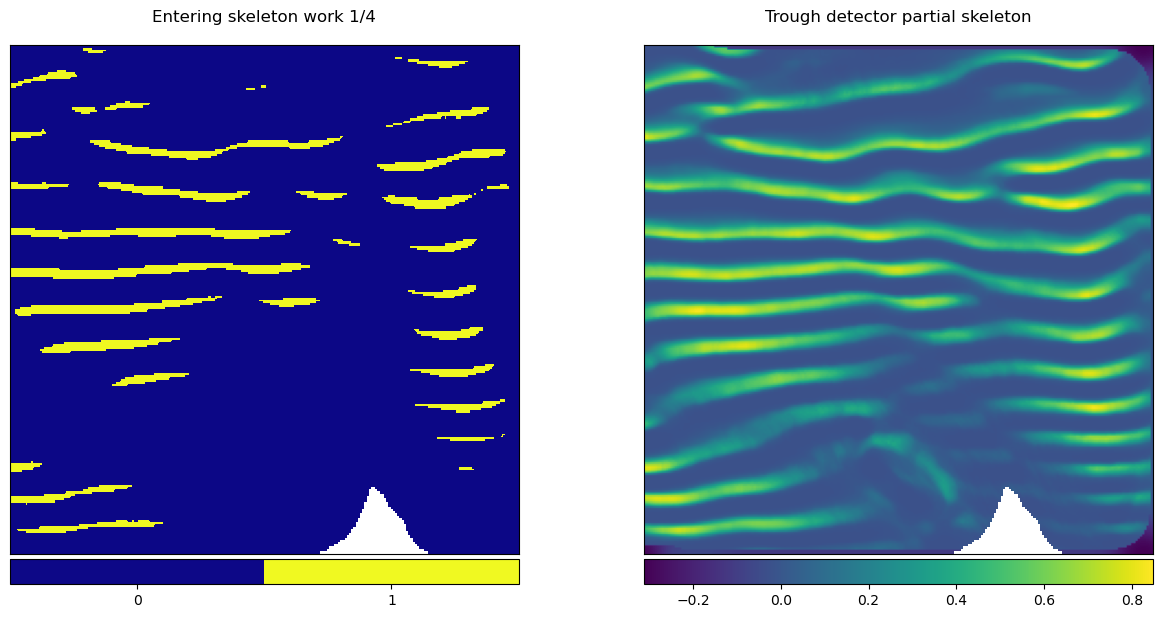

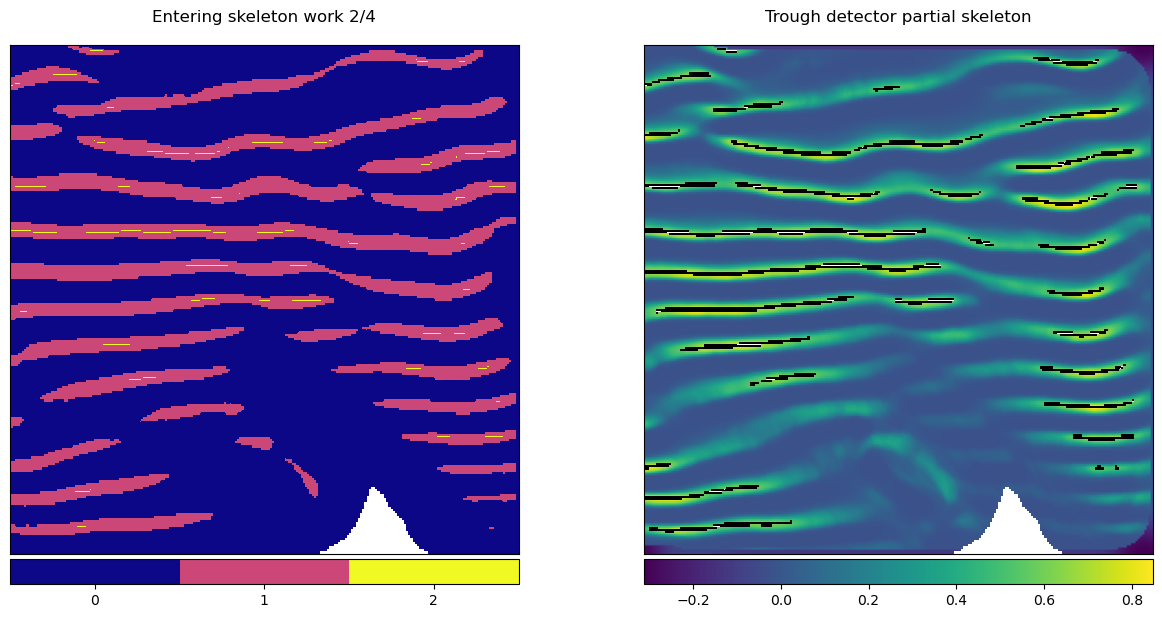

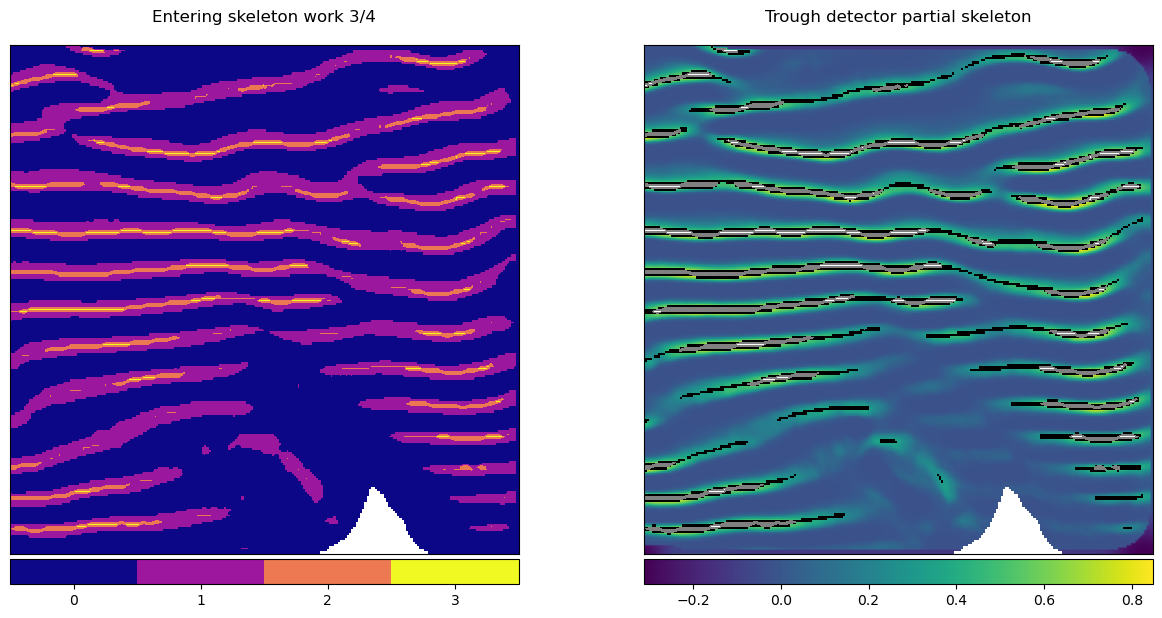

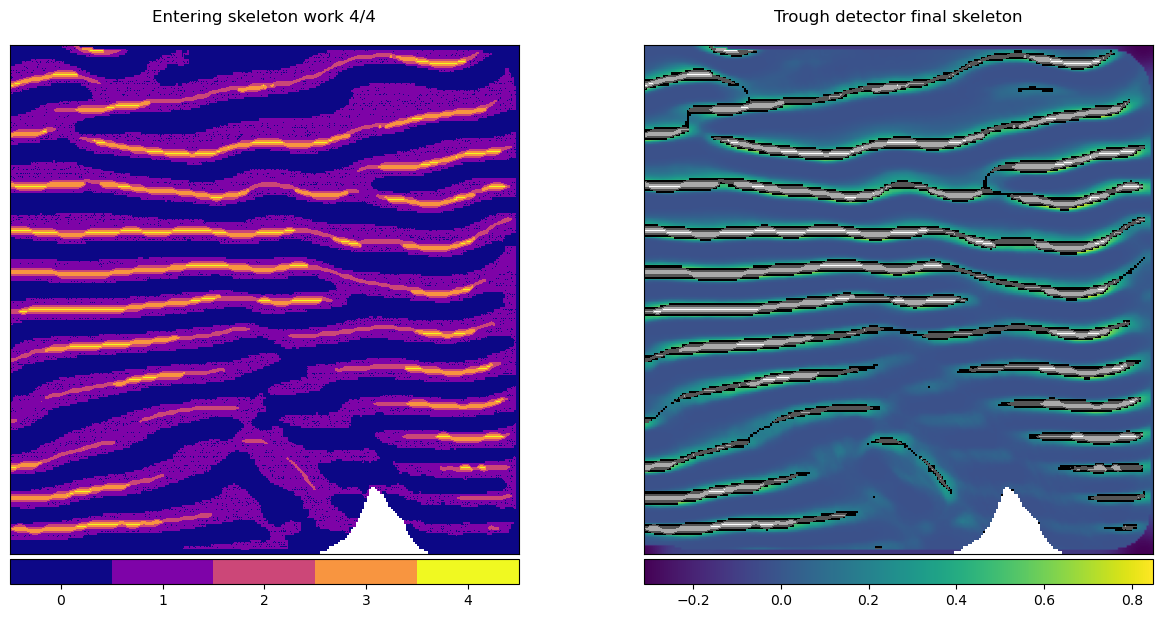

In [32]:
for_skeleton=model_for_trough_skeletonization(base_path=r'C:\Users\morawski-j\Desktop\JM_stage\Training_data\Skeletonization_inputs',idnum=87)#,VOVOP_treshold=0.1)
skeleton=for_skeleton.skeletonization(levels=[0.5,0.2,0.1,0],boolean=False,visual_control=True,crop_x=[0,1],crop_y=[0,1])